In [1]:
using Revise, Pkg
Pkg.activate("/home/louise/MSA/BpAlignGpu.jl")
using BpAlignGpu

  Activating project at `~/MSA/BpAlignGpu.jl`


In [2]:
using Plots, Statistics, DelimitedFiles

In [3]:
using CUDA
CUDA.device!(1)
CUDA.allowscalar(false)

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/louise/.julia/packages/CUDA/Uurn4/src/initialization.jl:70


In [4]:
T = Float32
q = 21
ctype=Symbol("amino")
typel=Symbol("bm");

In [5]:
muext = 0.00
muint = 2.50;

# -------------- Choose family --------------

In [6]:
fam = "PF00684"
open("/home/louise/MSA/Data/test/PF00684/")
L = 67; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00684/Parameters_bm_PF00684seed_potts.dat", q, L, gap=0, typel=typel);

delta = 50;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00684/Test_PF00684.full", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.fasta", "/home/louise/MSA/Data/test/PF00684/Test_PF00684.ins", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00684/Lambda_PF00684.dat")
lambda_o = Lambda_all[:,1];
lambda_e = Lambda_all[:,2];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [7]:
fam = "PF00397"
open("/home/louise/MSA/Data/test/PF00397/")
L = 31; 

J, H = BpAlignGpu.read_parameters("/home/louise/MSA/Data/test/PF00397/Parameters_plm_PF00397.dat", q, L, gap=0, typel=typel);

delta = 5;
al = BpAlignGpu.enveloptoalign( "/home/louise/MSA/Data/test/PF00397/PF00397_full_length_sequences.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.fasta", "/home/louise/MSA/Data/test/PF00397/PF00397_full.inse", delta = delta, ctype = ctype);
M = length(al)

Lambda_all = readdlm("/home/louise/MSA/Data/test/PF00397/Lambda_PF00397.dat")
lambda_o = Lambda_all[1,:];
lambda_e = Lambda_all[2,:];


┌ Info: Assuming J i j a b and h i a format
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:37
┌ Info: Output tersors: J[a b i j] and h[a i]
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:39
┌ Info: Gap in input file 0 now in 21
└ @ BpAlignGpu /home/louise/MSA/BpAlignGpu.jl/src/utils.jl:40


In [8]:
##Random Data
#(N, L) = (6, 5) 
##(N, L) = (161, 67)

#lambda_o = ones(L)
#lambda_e = ones(L)
#H = rand(q,L)
#J = rand(q,q,L,L)
#J = J .+ permutedims(J, (2,1,4,3));

In [9]:
(Nmin, Nmax) = extrema([length(al[idx0][2]) for idx0 in 1:M])
ibig = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmax)[1]
ismall = findall([length(al[idx0][2]) for idx0 in 1:M] .== Nmin)[1];
(Nmin, Nmax, M)

(22, 52, 59696)

# -------------- one sequence, one epsilon --------------

In [120]:
idx0 = rand(1:M)

23083

In [121]:
seq = BpAlignGpu.Seq(al[idx0][3], al[idx0][2], ctype)
@show seq
N = length(al[idx0][2])

seq = ---EWKEFTTPE-GRKYYFNKVTKQSKWSIP
ERADASTEWKEFTTPEGRKYYFNKVTKQSKWSIPDELKV


39

In [122]:
pm = ParamModel{T}(N, L, q, muint, muext, lambda_o, lambda_e, H, J)

ParamModel{Float32}[L=31 N=39 q=21 size=1.619 MiB]

In [123]:
#build paramalgo
damp=T(0.9)
tol=T(1e-3)
tolnorm=T(1e-10)
tmax=10
upscheme=:sequential 
initcond=:random 
lr=:sce  
beta=T(0.0)
verbose=false

ϵ = -0.0
xnsol = fill((0, 0), L);
epscoupling=(false, T(ϵ), xnsol)
#epscoupling=(true, T(ϵ), xnsol_0)
pa = ParamAlgo(damp, tol, tolnorm, tmax, upscheme, initcond, lr, beta, verbose, epscoupling)

ParamAlgo{Float32}
-------------
damp=0.9
tol=0.001
tolnorm=1.0e-10
tmax=10
upscheme=sequential
initcond=random
lr=sce
beta=0.0
verbose=false
epscoupling=false
-------------

In [124]:
bpm = BPMessages(seq, pm, pa)
bpb = BPBeliefs(N, L)
lrf = LongRangeFields(N, L)
af = AllFields(bpm, bpb, lrf)

AllFields{Float32}[L=31 N=39 ongpu=true size=50.977 MiB]

In [125]:
##find ground state
iters = 700
minpol = 0.90
nmax = 30
minbet = 0.01
@time beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, xnsol_ϵ, bel_ϵ = BpAlignGpu.findGS(af, pm, pa, seq, iters = iters, minpol = minpol, nmax = nmax, minbet = minbet);



beta = 0.0f0
converged: err=0.0009884462, tol=0.001, nbiter=57
(polar, energy, err) = (0.039412167f0, 40.630054f0, 0.0009884462f0)
beta = 0.1
converged: err=0.00096544623, tol=0.001, nbiter=41
(polar, energy, err) = (0.052080605f0, 31.723835f0, 0.00096544623f0)
beta = 0.2
converged: err=0.0009666085, tol=0.001, nbiter=45
(polar, energy, err) = (0.073024265f0, 3.7024221f0, 0.0009666085f0)
beta = 0.30000000000000004
converged: err=0.000990048, tol=0.001, nbiter=98
(polar, energy, err) = (0.14807047f0, -37.997944f0, 0.000990048f0)
beta = 0.4
converged: err=0.0009894967, tol=0.001, nbiter=222
(polar, energy, err) = (0.80067176f0, -52.47564f0, 0.0009894967f0)
beta = 0.5
converged: err=0.0009729862, tol=0.001, nbiter=89
(polar, energy, err) = (0.9314895f0, -55.754173f0, 0.0009729862f0)
 56.925958 seconds (30.82 M allocations: 1.577 GiB, 2.54% gc time, 1.00% compilation time)


In [126]:
beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ, exp(S_ϵ)

(0.5, 0.0009729862f0, 0.9314895f0, -55.754173f0, 0, -46.397823f0, 0.18657567424158897, 1.2051158148604972)

In [127]:
xnsol_vit, p_vit = BpAlignGpu.viterbi_decoding(af, pm)
c = BpAlignGpu.check_sr!(xnsol_vit, L, N)
@show sum(c)
seqsol_vit = BpAlignGpu.convert_soltosequence!(xnsol_vit, seq.strseq, N, L)
energy_vit = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_vit[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)


sum(c) = 0


-55.754173f0

In [128]:
U_ϵ, energy_ϵ, energy_vit

(-46.397823f0, -55.754173f0, -55.754173f0)

In [129]:
t_vit = zeros(size(bel_ϵ[:,:,:]))
t_maxP = zeros(size(bel_ϵ[:,:,:]))
for i=1:L
    n,x = xnsol_vit[i]
    t_vit[x+1, n+1, i] = 1.0
    n,x = xnsol_ϵ[i]
    t_maxP[x+1, n+1, i] = 1.0
end

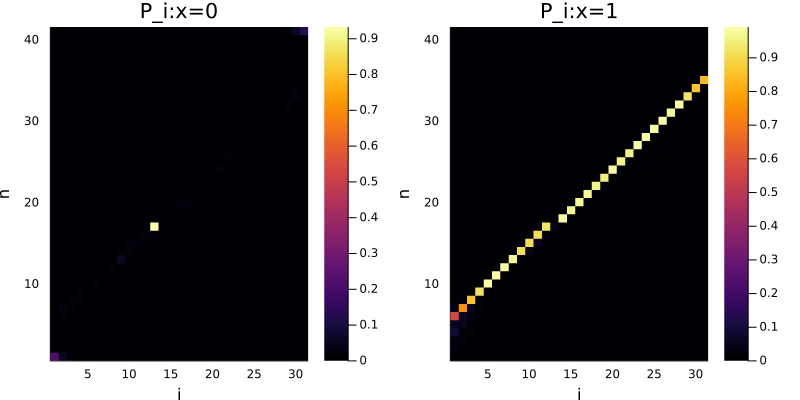

In [130]:
p0 = heatmap(bel_ϵ[:,1,:], xlabel="i", ylabel="n", title="P_i:x=0")
p1 = heatmap(bel_ϵ[:,2,:], xlabel="i", ylabel="n", title="P_i:x=1")
p = plot(p0, p1, size=(800,400))

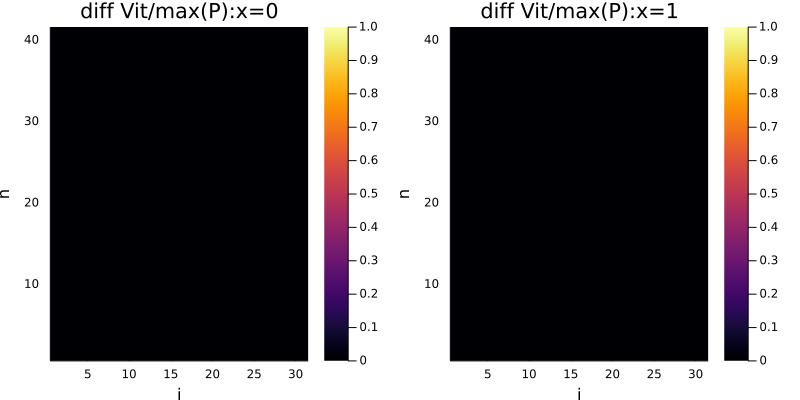

In [131]:
p2 = heatmap(t_vit[:,1,:] .- t_maxP[:,1,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=0")
p3 = heatmap(t_vit[:,2,:] .- t_maxP[:,2,:], xlabel="i", ylabel="n", title="diff Vit/max(P):x=1")
plot(p2,p3, size=(800,400))

# Sampling with Viterbi

In [132]:
ntrials = 5000
diffE_Vsamps = []
xnsols_SAMP = []
seqsols_SAMP = []
for i in 1:ntrials
    xnsol_sampled = BpAlignGpu.viterbi_sampling(af, pm);
    seqsol_samp = BpAlignGpu.convert_soltosequence!(xnsol_sampled, seq.strseq, N, L)
    energy_samp = BpAlignGpu.compute_cost_function(pm.J, pm.H, seqsol_samp[2], pm.L, seq.ctype, pm.lambda_o, pm.lambda_e, pm.muext, pm.muint)
    diffE = energy_samp - energy_vit
    append!(diffE_Vsamps, diffE)
    append!(xnsols_SAMP, [xnsol_sampled])
    append!(seqsols_SAMP, [seqsol_samp[1]])
    @show i, diffE
end

(i, diffE) = (1, 3.278534f0)
(i, diffE) = (2, 7.6457405f0)
(i, diffE) = (3, 17.417149f0)
(i, diffE) = (4, 14.002243f0)
(i, diffE) = (5, 0.0f0)
(i, diffE) = (6, 0.0f0)
(i, diffE) = (7, 15.415401f0)
(i, diffE) = (8, 10.462479f0)
(i, diffE) = (9, 9.494686f0)
(i, diffE) = (10, 8.594093f0)
(i, diffE) = (11, 0.0f0)
(i, diffE) = (12, 0.0f0)
(i, diffE) = (13, 26.527222f0)
(i, diffE) = (14, 9.545723f0)
(i, diffE) = (15, 0.0f0)
(i, diffE) = (16, 0.0f0)
(i, diffE) = (17, 10.835041f0)
(i, diffE) = (18, 12.40041f0)
(i, diffE) = (19, 0.0f0)
(i, diffE) = (20, 31.661922f0)
(i, diffE) = (21, 3.278534f0)
(i, diffE) = (22, 9.571014f0)
(i, diffE) = (23, 18.489319f0)
(i, diffE) = (24, 9.709927f0)
(i, diffE) = (25, 12.562328f0)
(i, diffE) = (26, 26.840343f0)
(i, diffE) = (27, 0.0f0)
(i, diffE) = (28, 0.0f0)
(i, diffE) = (29, 20.808056f0)
(i, diffE) = (30, 20.90575f0)
(i, diffE) = (31, 15.213367f0)
(i, diffE) = (32, 0.0f0)
(i, diffE) = (33, 34.813797f0)
(i, diffE) = (34, 0.0f0)
(i, diffE) = (35, 6.427025f0)


(i, diffE) = (349, 0.0f0)
(i, diffE) = (350, 6.6867065f0)
(i, diffE) = (351, 3.278534f0)
(i, diffE) = (352, 9.651691f0)
(i, diffE) = (353, 10.90086f0)
(i, diffE) = (354, 11.965275f0)
(i, diffE) = (355, 12.213078f0)
(i, diffE) = (356, 0.0f0)
(i, diffE) = (357, 16.237312f0)
(i, diffE) = (358, 8.594093f0)
(i, diffE) = (359, 0.0f0)
(i, diffE) = (360, 0.0f0)
(i, diffE) = (361, 8.779263f0)
(i, diffE) = (362, 0.0f0)
(i, diffE) = (363, 0.0f0)
(i, diffE) = (364, 8.663181f0)
(i, diffE) = (365, 16.690315f0)
(i, diffE) = (366, 6.6867065f0)
(i, diffE) = (367, 20.087006f0)
(i, diffE) = (368, 23.133533f0)
(i, diffE) = (369, 8.779263f0)
(i, diffE) = (370, 0.0f0)
(i, diffE) = (371, 0.0f0)
(i, diffE) = (372, 3.278534f0)
(i, diffE) = (373, 19.449299f0)
(i, diffE) = (374, 0.0f0)
(i, diffE) = (375, 40.105278f0)
(i, diffE) = (376, 17.31799f0)
(i, diffE) = (377, 0.0f0)
(i, diffE) = (378, 0.0f0)
(i, diffE) = (379, 31.520748f0)
(i, diffE) = (380, 17.810379f0)
(i, diffE) = (381, 0.0f0)
(i, diffE) = (382, 6.4270

(i, diffE) = (696, 3.278534f0)
(i, diffE) = (697, 0.0f0)
(i, diffE) = (698, 36.198578f0)
(i, diffE) = (699, 10.357288f0)
(i, diffE) = (700, 18.495571f0)
(i, diffE) = (701, 16.938118f0)
(i, diffE) = (702, 12.054661f0)
(i, diffE) = (703, 9.110153f0)
(i, diffE) = (704, 14.149475f0)
(i, diffE) = (705, 73.55359f0)
(i, diffE) = (706, 5.6613503f0)
(i, diffE) = (707, 0.0f0)
(i, diffE) = (708, 9.07859f0)
(i, diffE) = (709, 15.20665f0)
(i, diffE) = (710, 7.6457405f0)
(i, diffE) = (711, 30.545319f0)
(i, diffE) = (712, 0.0f0)
(i, diffE) = (713, 16.297565f0)
(i, diffE) = (714, 0.0f0)
(i, diffE) = (715, 10.728252f0)
(i, diffE) = (716, 0.0f0)
(i, diffE) = (717, 6.271084f0)
(i, diffE) = (718, 24.934162f0)
(i, diffE) = (719, 0.0f0)
(i, diffE) = (720, 6.427025f0)
(i, diffE) = (721, 0.0f0)
(i, diffE) = (722, 3.278534f0)
(i, diffE) = (723, 10.90086f0)
(i, diffE) = (724, 6.427025f0)
(i, diffE) = (725, 13.183144f0)
(i, diffE) = (726, 0.0f0)
(i, diffE) = (727, 12.2368965f0)
(i, diffE) = (728, 0.0f0)
(i, diff

(i, diffE) = (1037, 6.6867065f0)
(i, diffE) = (1038, 6.4679337f0)
(i, diffE) = (1039, 22.04052f0)
(i, diffE) = (1040, 0.0f0)
(i, diffE) = (1041, 6.6867065f0)
(i, diffE) = (1042, 9.929096f0)
(i, diffE) = (1043, 42.632973f0)
(i, diffE) = (1044, 9.027046f0)
(i, diffE) = (1045, 6.4679337f0)
(i, diffE) = (1046, 0.0f0)
(i, diffE) = (1047, 14.689129f0)
(i, diffE) = (1048, 5.6613503f0)
(i, diffE) = (1049, 14.303001f0)
(i, diffE) = (1050, 0.0f0)
(i, diffE) = (1051, 0.0f0)
(i, diffE) = (1052, 3.278534f0)
(i, diffE) = (1053, 11.99572f0)
(i, diffE) = (1054, 0.0f0)
(i, diffE) = (1055, 10.728252f0)
(i, diffE) = (1056, 3.278534f0)
(i, diffE) = (1057, 6.271084f0)
(i, diffE) = (1058, 3.278534f0)
(i, diffE) = (1059, 15.527874f0)
(i, diffE) = (1060, 6.0205154f0)
(i, diffE) = (1061, 18.858936f0)
(i, diffE) = (1062, 20.189041f0)
(i, diffE) = (1063, 24.757519f0)
(i, diffE) = (1064, 0.0f0)
(i, diffE) = (1065, 10.910648f0)
(i, diffE) = (1066, 19.93657f0)
(i, diffE) = (1067, 25.231117f0)
(i, diffE) = (1068, 0.

(i, diffE) = (1369, 35.596783f0)
(i, diffE) = (1370, 0.0f0)
(i, diffE) = (1371, 0.0f0)
(i, diffE) = (1372, 0.0f0)
(i, diffE) = (1373, 23.320774f0)
(i, diffE) = (1374, 25.088337f0)
(i, diffE) = (1375, 0.0f0)
(i, diffE) = (1376, 19.412365f0)
(i, diffE) = (1377, 11.513443f0)
(i, diffE) = (1378, 16.341503f0)
(i, diffE) = (1379, 0.0f0)
(i, diffE) = (1380, 23.391205f0)
(i, diffE) = (1381, 0.0f0)
(i, diffE) = (1382, 0.0f0)
(i, diffE) = (1383, 0.0f0)
(i, diffE) = (1384, 0.0f0)
(i, diffE) = (1385, 0.0f0)
(i, diffE) = (1386, 9.9691925f0)
(i, diffE) = (1387, 0.0f0)
(i, diffE) = (1388, 3.278534f0)
(i, diffE) = (1389, 0.0f0)
(i, diffE) = (1390, 20.742508f0)
(i, diffE) = (1391, 20.05975f0)
(i, diffE) = (1392, 0.0f0)
(i, diffE) = (1393, 0.0f0)
(i, diffE) = (1394, 14.913826f0)
(i, diffE) = (1395, 6.4679337f0)
(i, diffE) = (1396, 0.0f0)
(i, diffE) = (1397, 29.823032f0)
(i, diffE) = (1398, 0.0f0)
(i, diffE) = (1399, 18.131638f0)
(i, diffE) = (1400, 0.0f0)
(i, diffE) = (1401, 0.0f0)
(i, diffE) = (1402, 1

(i, diffE) = (1701, 9.176476f0)
(i, diffE) = (1702, 0.0f0)
(i, diffE) = (1703, 0.0f0)
(i, diffE) = (1704, 10.883053f0)
(i, diffE) = (1705, 6.4679337f0)
(i, diffE) = (1706, 0.0f0)
(i, diffE) = (1707, 7.6457405f0)
(i, diffE) = (1708, 10.175949f0)
(i, diffE) = (1709, 0.0f0)
(i, diffE) = (1710, 0.0f0)
(i, diffE) = (1711, 9.044926f0)
(i, diffE) = (1712, 9.027046f0)
(i, diffE) = (1713, 10.934635f0)
(i, diffE) = (1714, 7.56271f0)
(i, diffE) = (1715, 29.569378f0)
(i, diffE) = (1716, 15.397732f0)
(i, diffE) = (1717, 19.895279f0)
(i, diffE) = (1718, 0.0f0)
(i, diffE) = (1719, 18.78683f0)
(i, diffE) = (1720, 0.0f0)
(i, diffE) = (1721, 12.5891075f0)
(i, diffE) = (1722, 0.0f0)
(i, diffE) = (1723, 0.0f0)
(i, diffE) = (1724, 7.6457405f0)
(i, diffE) = (1725, 7.6457405f0)
(i, diffE) = (1726, 12.15089f0)
(i, diffE) = (1727, 3.278534f0)
(i, diffE) = (1728, 13.900089f0)
(i, diffE) = (1729, 9.044926f0)
(i, diffE) = (1730, 0.0f0)
(i, diffE) = (1731, 9.444218f0)
(i, diffE) = (1732, 20.58591f0)
(i, diffE) = (

(i, diffE) = (2033, 6.271084f0)
(i, diffE) = (2034, 9.176476f0)
(i, diffE) = (2035, 6.427025f0)
(i, diffE) = (2036, 9.01907f0)
(i, diffE) = (2037, 15.125912f0)
(i, diffE) = (2038, 0.0f0)
(i, diffE) = (2039, 9.63369f0)
(i, diffE) = (2040, 8.779263f0)
(i, diffE) = (2041, 10.1426735f0)
(i, diffE) = (2042, 20.876564f0)
(i, diffE) = (2043, 0.0f0)
(i, diffE) = (2044, 0.0f0)
(i, diffE) = (2045, 9.110153f0)
(i, diffE) = (2046, 9.444218f0)
(i, diffE) = (2047, 6.427025f0)
(i, diffE) = (2048, 0.0f0)
(i, diffE) = (2049, 8.594093f0)
(i, diffE) = (2050, 15.276852f0)
(i, diffE) = (2051, 7.6457405f0)
(i, diffE) = (2052, 24.318825f0)
(i, diffE) = (2053, 0.0f0)
(i, diffE) = (2054, 12.61314f0)
(i, diffE) = (2055, 3.278534f0)
(i, diffE) = (2056, 8.815025f0)
(i, diffE) = (2057, 7.5285835f0)
(i, diffE) = (2058, 0.0f0)
(i, diffE) = (2059, 31.232681f0)
(i, diffE) = (2060, 19.142792f0)
(i, diffE) = (2061, 0.0f0)
(i, diffE) = (2062, 16.141022f0)
(i, diffE) = (2063, 0.0f0)
(i, diffE) = (2064, 9.545723f0)
(i, dif

(i, diffE) = (2369, 0.0f0)
(i, diffE) = (2370, 6.6867065f0)
(i, diffE) = (2371, 7.5285835f0)
(i, diffE) = (2372, 3.278534f0)
(i, diffE) = (2373, 14.535358f0)
(i, diffE) = (2374, 0.0f0)
(i, diffE) = (2375, 9.044926f0)
(i, diffE) = (2376, 8.896328f0)
(i, diffE) = (2377, 3.278534f0)
(i, diffE) = (2378, 0.0f0)
(i, diffE) = (2379, 0.0f0)
(i, diffE) = (2380, 20.32946f0)
(i, diffE) = (2381, 29.575897f0)
(i, diffE) = (2382, 13.777969f0)
(i, diffE) = (2383, 32.704266f0)
(i, diffE) = (2384, 6.271084f0)
(i, diffE) = (2385, 7.5285835f0)
(i, diffE) = (2386, 6.6867065f0)
(i, diffE) = (2387, 0.0f0)
(i, diffE) = (2388, 0.0f0)
(i, diffE) = (2389, 11.748981f0)
(i, diffE) = (2390, 24.009243f0)
(i, diffE) = (2391, 3.278534f0)
(i, diffE) = (2392, 9.34927f0)
(i, diffE) = (2393, 0.0f0)
(i, diffE) = (2394, 0.0f0)
(i, diffE) = (2395, 51.693844f0)
(i, diffE) = (2396, 18.341663f0)
(i, diffE) = (2397, 12.429848f0)
(i, diffE) = (2398, 0.0f0)
(i, diffE) = (2399, 14.380371f0)
(i, diffE) = (2400, 19.595612f0)
(i, dif

(i, diffE) = (2703, 0.0f0)
(i, diffE) = (2704, 12.429848f0)
(i, diffE) = (2705, 9.044926f0)
(i, diffE) = (2706, 16.110905f0)
(i, diffE) = (2707, 0.0f0)
(i, diffE) = (2708, 19.336826f0)
(i, diffE) = (2709, 22.876461f0)
(i, diffE) = (2710, 0.0f0)
(i, diffE) = (2711, 3.278534f0)
(i, diffE) = (2712, 0.0f0)
(i, diffE) = (2713, 0.0f0)
(i, diffE) = (2714, 26.16f0)
(i, diffE) = (2715, 9.709927f0)
(i, diffE) = (2716, 0.0f0)
(i, diffE) = (2717, 0.0f0)
(i, diffE) = (2718, 0.0f0)
(i, diffE) = (2719, 9.110153f0)
(i, diffE) = (2720, 8.40905f0)
(i, diffE) = (2721, 3.278534f0)
(i, diffE) = (2722, 0.0f0)
(i, diffE) = (2723, 0.0f0)
(i, diffE) = (2724, 6.0205154f0)
(i, diffE) = (2725, 0.0f0)
(i, diffE) = (2726, 18.850998f0)
(i, diffE) = (2727, 20.624722f0)
(i, diffE) = (2728, 0.0f0)
(i, diffE) = (2729, 16.144905f0)
(i, diffE) = (2730, 10.357288f0)
(i, diffE) = (2731, 9.176476f0)
(i, diffE) = (2732, 0.0f0)
(i, diffE) = (2733, 17.535786f0)
(i, diffE) = (2734, 8.896328f0)
(i, diffE) = (2735, 0.0f0)
(i, diff

(i, diffE) = (3037, 13.778496f0)
(i, diffE) = (3038, 3.278534f0)
(i, diffE) = (3039, 3.278534f0)
(i, diffE) = (3040, 6.4679337f0)
(i, diffE) = (3041, 13.856747f0)
(i, diffE) = (3042, 0.0f0)
(i, diffE) = (3043, 21.130878f0)
(i, diffE) = (3044, 0.0f0)
(i, diffE) = (3045, 12.900372f0)
(i, diffE) = (3046, 8.663181f0)
(i, diffE) = (3047, 3.278534f0)
(i, diffE) = (3048, 18.50504f0)
(i, diffE) = (3049, 3.278534f0)
(i, diffE) = (3050, 20.898453f0)
(i, diffE) = (3051, 14.782841f0)
(i, diffE) = (3052, 8.595989f0)
(i, diffE) = (3053, 27.490513f0)
(i, diffE) = (3054, 21.764408f0)
(i, diffE) = (3055, 0.0f0)
(i, diffE) = (3056, 30.407349f0)
(i, diffE) = (3057, 9.970142f0)
(i, diffE) = (3058, 0.0f0)
(i, diffE) = (3059, 0.0f0)
(i, diffE) = (3060, 0.0f0)
(i, diffE) = (3061, 11.722851f0)
(i, diffE) = (3062, 11.890991f0)
(i, diffE) = (3063, 0.0f0)
(i, diffE) = (3064, 25.179203f0)
(i, diffE) = (3065, 0.0f0)
(i, diffE) = (3066, 18.804565f0)
(i, diffE) = (3067, 7.56271f0)
(i, diffE) = (3068, 27.7463f0)
(i, 

(i, diffE) = (3367, 36.236057f0)
(i, diffE) = (3368, 0.0f0)
(i, diffE) = (3369, 0.0f0)
(i, diffE) = (3370, 18.339695f0)
(i, diffE) = (3371, 8.815025f0)
(i, diffE) = (3372, 15.334778f0)
(i, diffE) = (3373, 9.272282f0)
(i, diffE) = (3374, 0.0f0)
(i, diffE) = (3375, 69.37507f0)
(i, diffE) = (3376, 18.32927f0)
(i, diffE) = (3377, 28.248314f0)
(i, diffE) = (3378, 0.0f0)
(i, diffE) = (3379, 5.6613503f0)
(i, diffE) = (3380, 20.644459f0)
(i, diffE) = (3381, 7.5285835f0)
(i, diffE) = (3382, 18.978226f0)
(i, diffE) = (3383, 10.918304f0)
(i, diffE) = (3384, 6.271084f0)
(i, diffE) = (3385, 6.0205154f0)
(i, diffE) = (3386, 22.850555f0)
(i, diffE) = (3387, 28.53815f0)
(i, diffE) = (3388, 0.0f0)
(i, diffE) = (3389, 6.271084f0)
(i, diffE) = (3390, 8.132511f0)
(i, diffE) = (3391, 6.271084f0)
(i, diffE) = (3392, 0.0f0)
(i, diffE) = (3393, 0.0f0)
(i, diffE) = (3394, 5.6613503f0)
(i, diffE) = (3395, 0.0f0)
(i, diffE) = (3396, 19.807457f0)
(i, diffE) = (3397, 9.63369f0)
(i, diffE) = (3398, 0.0f0)
(i, diffE

(i, diffE) = (3701, 0.0f0)
(i, diffE) = (3702, 6.0205154f0)
(i, diffE) = (3703, 0.0f0)
(i, diffE) = (3704, 12.520493f0)
(i, diffE) = (3705, 6.4679337f0)
(i, diffE) = (3706, 40.83646f0)
(i, diffE) = (3707, 12.2368965f0)
(i, diffE) = (3708, 21.383408f0)
(i, diffE) = (3709, 19.591984f0)
(i, diffE) = (3710, 9.836479f0)
(i, diffE) = (3711, 0.0f0)
(i, diffE) = (3712, 0.0f0)
(i, diffE) = (3713, 12.598812f0)
(i, diffE) = (3714, 19.843693f0)
(i, diffE) = (3715, 9.545723f0)
(i, diffE) = (3716, 11.748981f0)
(i, diffE) = (3717, 32.90731f0)
(i, diffE) = (3718, 0.0f0)
(i, diffE) = (3719, 0.0f0)
(i, diffE) = (3720, 0.0f0)
(i, diffE) = (3721, 15.783844f0)
(i, diffE) = (3722, 9.027046f0)
(i, diffE) = (3723, 9.545723f0)
(i, diffE) = (3724, 13.729f0)
(i, diffE) = (3725, 0.0f0)
(i, diffE) = (3726, 0.0f0)
(i, diffE) = (3727, 0.0f0)
(i, diffE) = (3728, 12.319149f0)
(i, diffE) = (3729, 13.134483f0)
(i, diffE) = (3730, 0.0f0)
(i, diffE) = (3731, 3.278534f0)
(i, diffE) = (3732, 15.441669f0)
(i, diffE) = (3733,

(i, diffE) = (4030, 0.0f0)
(i, diffE) = (4031, 0.0f0)
(i, diffE) = (4032, 25.316936f0)
(i, diffE) = (4033, 0.0f0)
(i, diffE) = (4034, 9.044926f0)
(i, diffE) = (4035, 9.444218f0)
(i, diffE) = (4036, 0.0f0)
(i, diffE) = (4037, 13.386745f0)
(i, diffE) = (4038, 30.513702f0)
(i, diffE) = (4039, 5.6613503f0)
(i, diffE) = (4040, 9.176476f0)
(i, diffE) = (4041, 0.0f0)
(i, diffE) = (4042, 0.0f0)
(i, diffE) = (4043, 0.0f0)
(i, diffE) = (4044, 0.0f0)
(i, diffE) = (4045, 0.0f0)
(i, diffE) = (4046, 0.0f0)
(i, diffE) = (4047, 16.04692f0)
(i, diffE) = (4048, 16.027046f0)
(i, diffE) = (4049, 23.418179f0)
(i, diffE) = (4050, 6.0205154f0)
(i, diffE) = (4051, 20.434189f0)
(i, diffE) = (4052, 21.166859f0)
(i, diffE) = (4053, 0.0f0)
(i, diffE) = (4054, 0.0f0)
(i, diffE) = (4055, 3.278534f0)
(i, diffE) = (4056, 3.278534f0)
(i, diffE) = (4057, 8.815025f0)
(i, diffE) = (4058, 0.0f0)
(i, diffE) = (4059, 24.533379f0)
(i, diffE) = (4060, 7.5285835f0)
(i, diffE) = (4061, 16.56897f0)
(i, diffE) = (4062, 3.278534f0

(i, diffE) = (4363, 24.627758f0)
(i, diffE) = (4364, 9.63369f0)
(i, diffE) = (4365, 0.0f0)
(i, diffE) = (4366, 0.0f0)
(i, diffE) = (4367, 15.543125f0)
(i, diffE) = (4368, 22.305725f0)
(i, diffE) = (4369, 12.40041f0)
(i, diffE) = (4370, 16.53595f0)
(i, diffE) = (4371, 8.621143f0)
(i, diffE) = (4372, 0.0f0)
(i, diffE) = (4373, 5.6613503f0)
(i, diffE) = (4374, 0.0f0)
(i, diffE) = (4375, 0.0f0)
(i, diffE) = (4376, 8.874008f0)
(i, diffE) = (4377, 0.0f0)
(i, diffE) = (4378, 6.6867065f0)
(i, diffE) = (4379, 3.278534f0)
(i, diffE) = (4380, 16.360947f0)
(i, diffE) = (4381, 12.763248f0)
(i, diffE) = (4382, 11.360722f0)
(i, diffE) = (4383, 0.0f0)
(i, diffE) = (4384, 19.204414f0)
(i, diffE) = (4385, 17.439068f0)
(i, diffE) = (4386, 10.918304f0)
(i, diffE) = (4387, 13.600269f0)
(i, diffE) = (4388, 0.0f0)
(i, diffE) = (4389, 6.427025f0)
(i, diffE) = (4390, 0.0f0)
(i, diffE) = (4391, 7.56271f0)
(i, diffE) = (4392, 0.0f0)
(i, diffE) = (4393, 9.339439f0)
(i, diffE) = (4394, 21.057419f0)
(i, diffE) = (4

(i, diffE) = (4695, 14.548969f0)
(i, diffE) = (4696, 0.0f0)
(i, diffE) = (4697, 18.633984f0)
(i, diffE) = (4698, 0.0f0)
(i, diffE) = (4699, 9.044926f0)
(i, diffE) = (4700, 0.0f0)
(i, diffE) = (4701, 0.0f0)
(i, diffE) = (4702, 19.605404f0)
(i, diffE) = (4703, 9.308376f0)
(i, diffE) = (4704, 13.349445f0)
(i, diffE) = (4705, 12.215866f0)
(i, diffE) = (4706, 8.663181f0)
(i, diffE) = (4707, 0.0f0)
(i, diffE) = (4708, 0.0f0)
(i, diffE) = (4709, 14.167549f0)
(i, diffE) = (4710, 7.6457405f0)
(i, diffE) = (4711, 15.631493f0)
(i, diffE) = (4712, 0.0f0)
(i, diffE) = (4713, 21.073689f0)
(i, diffE) = (4714, 12.454792f0)
(i, diffE) = (4715, 0.0f0)
(i, diffE) = (4716, 8.874008f0)
(i, diffE) = (4717, 9.044926f0)
(i, diffE) = (4718, 19.11023f0)
(i, diffE) = (4719, 0.0f0)
(i, diffE) = (4720, 3.278534f0)
(i, diffE) = (4721, 3.278534f0)
(i, diffE) = (4722, 9.63369f0)
(i, diffE) = (4723, 0.0f0)
(i, diffE) = (4724, 10.542576f0)
(i, diffE) = (4725, 24.624111f0)
(i, diffE) = (4726, 21.17419f0)
(i, diffE) = (4

In [133]:
length(seqsols_SAMP |> unique)

1298

In [134]:
include("results/functions_seq_based_metrics.jl")

count_mismatch (generic function with 1 method)

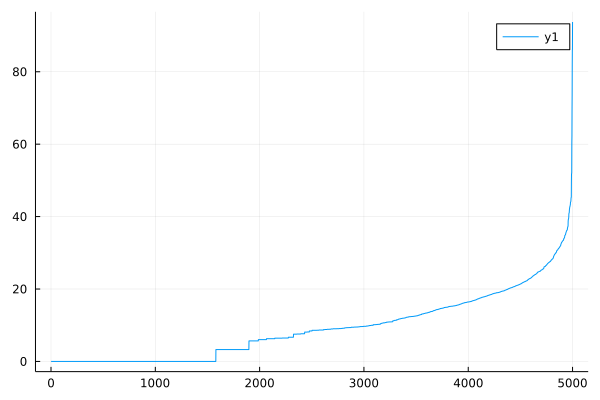

In [135]:
p1 = plot(sort(diffE_Vsamps,rev=false))

In [136]:
seqsol_ref_hmmer = al[idx0][3]

"---EWKEFTTPE-GRKYYFNKVTKQSKWSIP"

In [137]:
seqsol_ref = seqsol_vit[1]

"ASTEWKEFTTPE-GRKYYFNKVTKQSKWSIP"

In [138]:
hamming_distance(seqsol_ref_hmmer, seqsol_ref)

3

In [139]:
Hdist = []
for i in eachindex(seqsols_SAMP)
    dist = hamming_distance(seqsol_ref, seqsols_SAMP[i])
    append!(Hdist, dist)
end

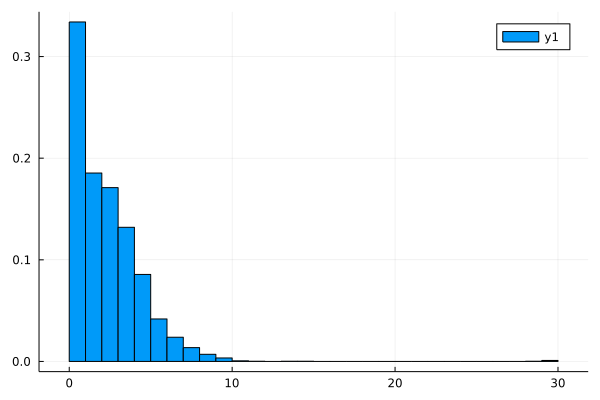

In [140]:
histogram(Hdist, bins = 50, normed = true)


In [141]:
Gp = []
Gm = []
for i in eachindex(seqsols_SAMP)
    np, nm = count_gap_pm(seqsol_ref, seqsols_SAMP[i])
    append!(Gp, np)
    append!(Gm, nm)
end

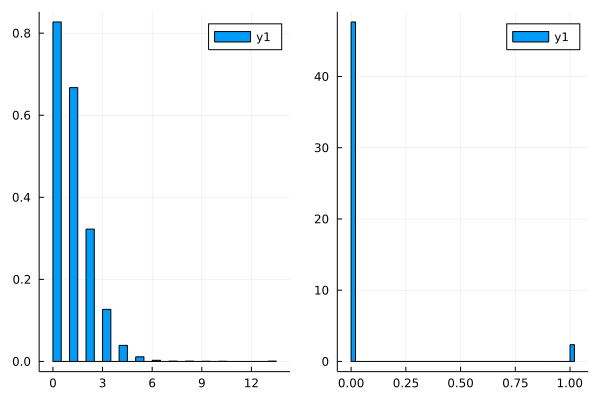

In [142]:
pp = histogram(Gp, bins = 50, normed = true)
pm = histogram(Gm, bins = 50, normed = true)
plot(pp, pm)

In [143]:
Mism = []
for i in eachindex(seqsols_SAMP)
    m = count_mismatch(seqsol_ref, seqsols_SAMP[i])
    append!(Mism, m)
end

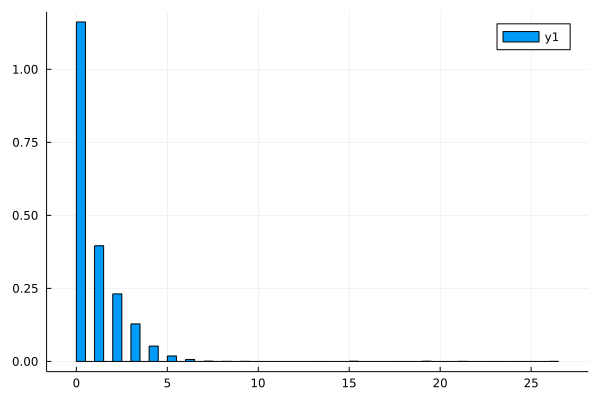

In [144]:
histogram(Mism, bins = 50, normed = true)

In [145]:
[Hdist[1:10], dists_Vsamps[1:10]]

2-element Vector{Vector{Any}}:
 [1, 2, 5, 2, 0, 0, 2, 2, 2, 2]
 [8, 7, 0, 1, 0, 3, 0, 3, 1, 2]

In [146]:
seqsols_SAMP[1:10]

10-element Vector{Any}:
 "-STEWKEFTTPE-GRKYYFNKVTKQSKWSIP"
 "DATEWKEFTTPE-GRKYYFNKVTKQSKWSIP"
 "---EWKEF-TTE-GRKYYFNKVTKQSKWSIP"
 "EATEWKEFTTPE-GRKYYFNKVTKQSKWSIP"
 "ASTEWKEFTTPE-GRKYYFNKVTKQSKWSIP"
 "ASTEWKEFTTPE-GRKYYFNKVTKQSKWSIP"
 "ASTEWKEFTTPE-GRKYYFNKVTKQSKWSK-"
 "ASTEWKEFTTPE-GRKYYFNKVTKQSKW-SP"
 "ASTEWKEFTTPE-GRKYYFNV-TKQSKWSIP"
 "ASTEWKEFTTP-EGRKYYFNKVTKQSKWSIP"

In [147]:
paramrun = [fam, L, M, delta, pa.damp, pa.tol, pa.tolnorm, pa.initcond, pa.lr, iters, minpol, nmax, minbet]
results = [beta_ϵ, err_ϵ, polar_ϵ, energy_ϵ, check_ϵ, U_ϵ, S_ϵ]
x0 = [x[1] for x in xnsol_vit]
x1 = [x[2] for x in xnsol_vit]
xc = vcat(x0, x1);


In [148]:
namefile = "Viterbi_sampling_"*string(idx0)*".txt"
open(namefile, "a") do io
    writedlm(io, [idx0 al[idx0][1]])
    writedlm(io, [paramrun])
    writedlm(io, [results])
    writedlm(io, [xc])
    writedlm(io, [diffE_Vsamps])
    writedlm(io, [Hdist])
    writedlm(io, [Gp])
    writedlm(io, [Gm])
    writedlm(io, [Mism])
end    
